In [1]:
%matplotlib notebook

### Import bibliotek

In [2]:
import os
import numpy as np
import rasterio as rio
import rasterio.mask as rmask
import fiona as fio
import matplotlib.pyplot as plt

### Funkcja wczytująca adresy plików do przetworzenia

In [3]:
def wczytaj_obrazy_landsat(nazwa_folderu):
    """Funkcja zwraca słownik (dict) z parami NUMER KANAŁU: ścieżka_do_pliku
    return: {numer_kanalu: sciezka_do_pliku}"""
    lista_plikow = os.listdir(nazwa_folderu)
    lista_kanalow = []
    for plik in lista_plikow:
        if (plik.startswith('LC') and plik.endswith('.tif')):
            if 'band' in plik:
                lista_kanalow.append(nazwa_folderu + plik)             
    lista_kanalow.sort()
    numery_kanalow = np.arange(1, 8)
    slownik_z_lista_kanalow = dict(zip(numery_kanalow, lista_kanalow))
    return slownik_z_lista_kanalow

# Test
lista_obrazow = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')
for kanal in lista_obrazow:
    print(kanal, lista_obrazow[kanal])

1 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band1.tif
2 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band2.tif
3 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band3.tif
4 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band4.tif
5 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band5.tif
6 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band6.tif
7 LC081880252013080701T1-SC20180329040242/LC08_L1TP_188025_20130807_20170503_01_T1_sr_band7.tif


### Funkcja do wyświetlania obrazów

<IPython.core.display.Javascript object>


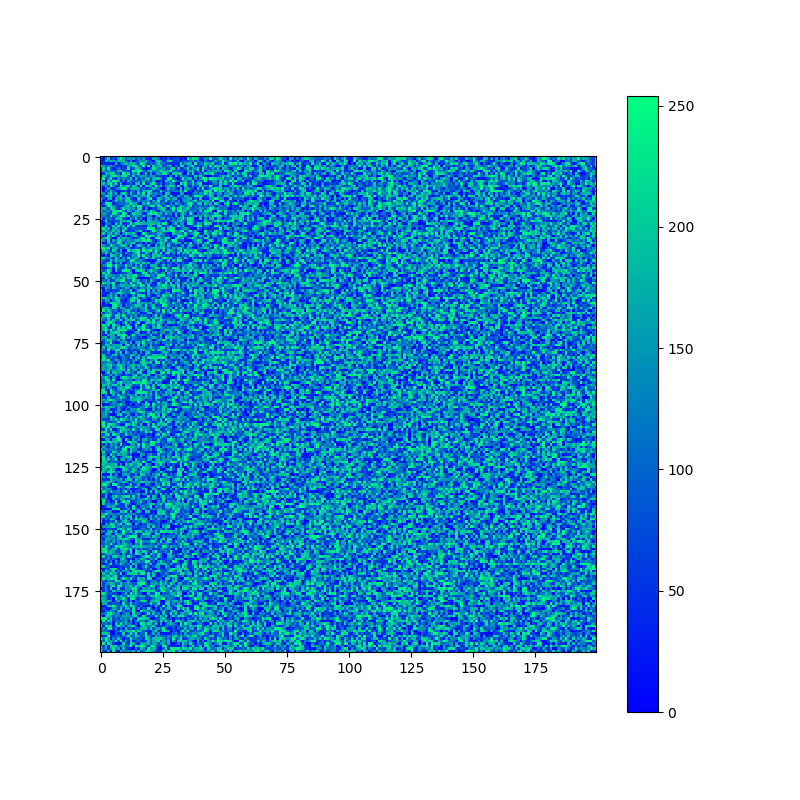

In [4]:
def wyswietl_obraz(obraz, mapa_kolorow='gray'):
    fig = plt.figure(figsize=(8,8))
    warstwa_obrazu = plt.imshow(obraz)
    warstwa_obrazu.set_cmap(mapa_kolorow)
    plt.colorbar()
    plt.show()
    
# Test
test = np.random.randint(low=0, high=255, size=(200, 200))
wyswietl_obraz(test, mapa_kolorow='winter')

### Wczytanie listy dostępnych kanałów i wyświetlenie przykładowego obrazu

<IPython.core.display.Javascript object>


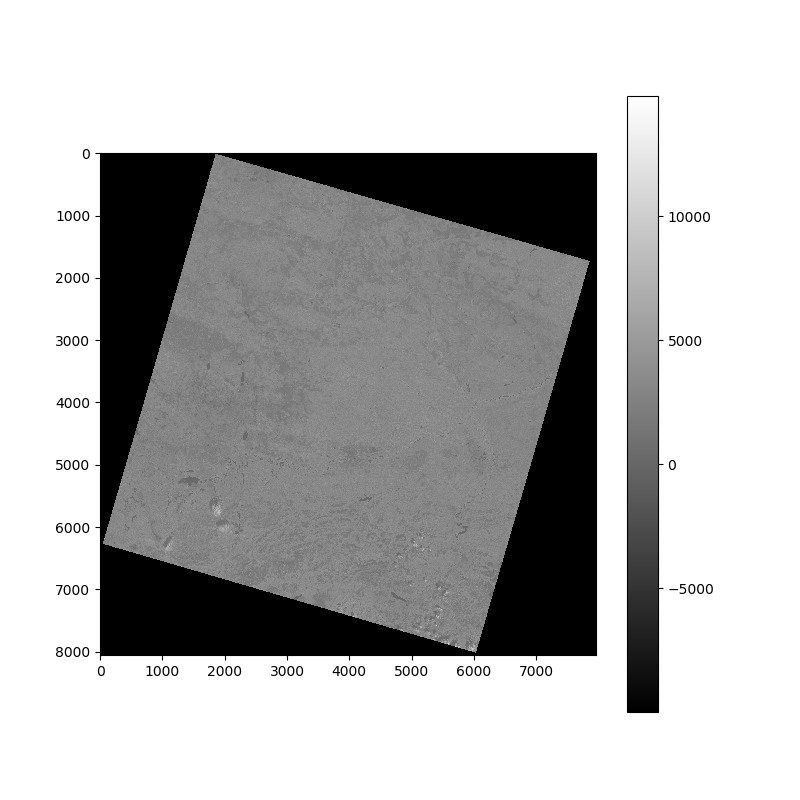

In [5]:
lista_obrazow = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')

with rio.open(lista_obrazow[5], 'r') as src:
    macierz_kanalu = src.read(1)
    
wyswietl_obraz(macierz_kanalu)

### Usunięcie wartości oznaczających brak danych, poprawa funkcji do wyświetlania obrazów

<IPython.core.display.Javascript object>


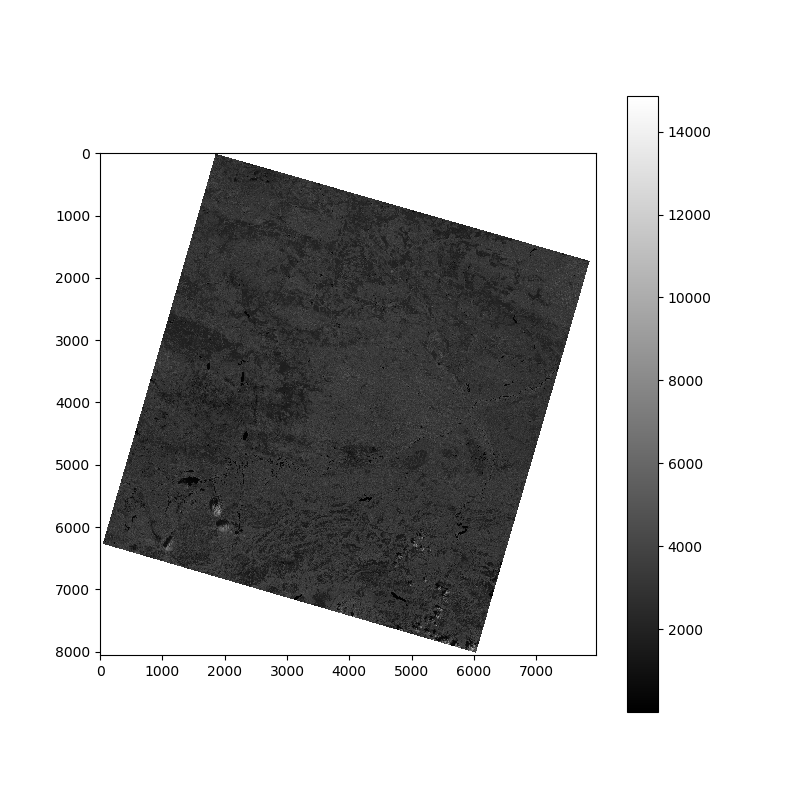

In [6]:
def wyswietl_obraz(obraz, mapa_kolorow='gray', usun_ujemne=True):
    macierz = obraz.astype(float)
    if usun_ujemne:
        macierz[macierz <= 0] = np.nan
    fig = plt.figure(figsize=(8,8))
    warstwa_obrazu = plt.imshow(macierz)
    warstwa_obrazu.set_cmap(mapa_kolorow)
    plt.colorbar()
    plt.show()
    
wyswietl_obraz(macierz_kanalu)

### Wycięcie obszaru zainteresowania z rastra

In [7]:
def wytnij_obszar(wektor_adres, raster_adres, adres_zapisu):

    with fio.open(wektor_adres, 'r') as wektor_zrodlo:
        geometria = [feature["geometry"] for feature in wektor_zrodlo]

    with rio.open(raster_adres, 'r') as r_zrodlo:
        wyciety_obraz, transformacja = rmask.mask(r_zrodlo, geometria, crop=True)
        metadane_obrazu = r_zrodlo.meta.copy()
        
    metadane_obrazu.update({"driver": "GTiff",
                 "height": wyciety_obraz.shape[1],
                 "width": wyciety_obraz.shape[2],
                 "transform": transformacja})
    with rio.open(adres_zapisu, "w", **metadane_obrazu) as nowy_g_tiff:
        nowy_g_tiff.write(wyciety_obraz)

### Przetworzenie rastrów do postaci obejmującej obszar zainteresowań

In [8]:
# 1. Wczytanie plików obrazów i sporządzenie ich listy

lista_obrazow = wczytaj_obrazy_landsat('LC081880252013080701T1-SC20180329040242/')

In [9]:
# 2. Wycięcie obszaru zainteresowania z każdego pliku

wektor = 'vector/krakow_krakowskie.shp'
wyciete = 'clipped/'
for kanal in lista_obrazow:
    miejsce_zapisu = wyciete + 'LC_clipped_band' + str(kanal) + '.tif'
    wytnij_obszar(wektor, lista_obrazow[kanal], miejsce_zapisu)

In [10]:
# 3. Wczytanie listy przetworzonych plików

lista_wycietych_obrazow = wczytaj_obrazy_landsat('clipped/')
for kanal in lista_wycietych_obrazow:
    print(lista_wycietych_obrazow[kanal])

clipped/LC_clipped_band1.tif
clipped/LC_clipped_band2.tif
clipped/LC_clipped_band3.tif
clipped/LC_clipped_band4.tif
clipped/LC_clipped_band5.tif
clipped/LC_clipped_band6.tif
clipped/LC_clipped_band7.tif


<IPython.core.display.Javascript object>


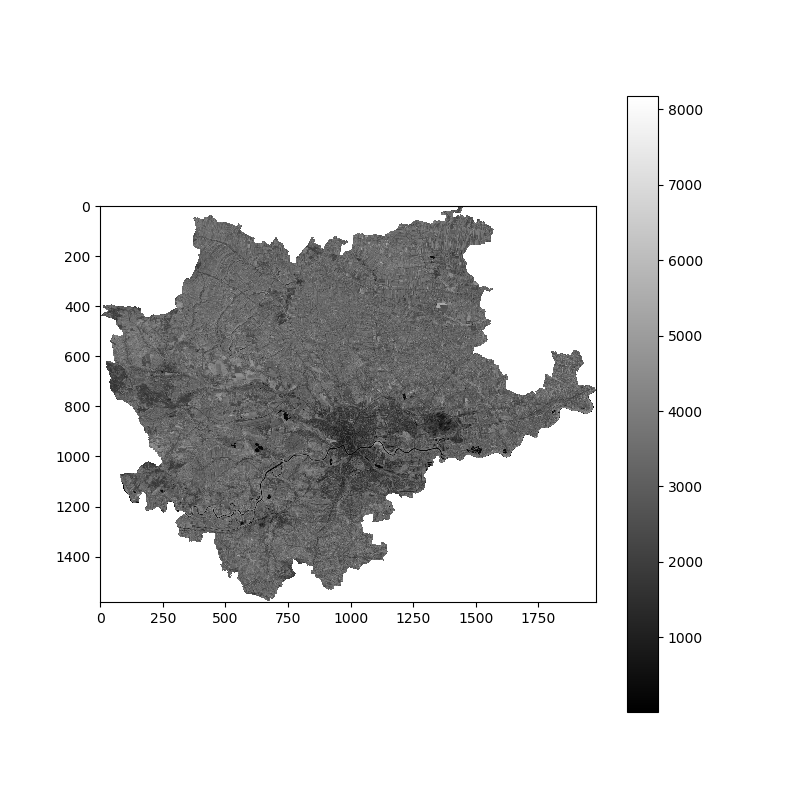

In [11]:
# 4. Wyświetlenie przykładowego pliku

with rio.open(lista_wycietych_obrazow[5], 'r') as src:
    macierz_kanalu = src.read(1)
    
wyswietl_obraz(macierz_kanalu)

### Wskaźniki, które można pozyskać z danych satelitarnych

In [12]:
def oblicz_wskaznik(nazwa_wskaznika, lista_plikow_landsat_8):
    wskazniki = {
        'ndvi': (5, 4),
        'ndbi': (6, 5),
        'ndwi': (3, 6),
    }
    
    # Magiczne 10000 przez które dzielone są piksele poszczególnych obrazów
    # to maksymalna wartość pikseli w produktach poziomu 2 satelity Landsat 8
    
    if nazwa_wskaznika in wskazniki:
        kanaly = wskazniki[nazwa_wskaznika]
        
        with rio.open(lista_plikow_landsat_8[kanaly[0]]) as a:
            kanal_a = (a.read()[0]/10000).astype(np.float)
        with rio.open(lista_plikow_landsat_8[kanaly[1]]) as b:
            kanal_b = (b.read()[0]/10000).astype(np.float)
        
        licznik = kanal_a - kanal_b
        mianownik = kanal_a + kanal_b
        
        wskaznik = licznik / mianownik
        wskaznik[wskaznik > 1] = 1
        wskaznik[wskaznik < -1] = -1
        
        return wskaznik
    else:
        raise ValueError('Brak wskaźnika do wyboru, dostępne wskaźniki to ndbi, ndvi i ndwi')

<IPython.core.display.Javascript object>


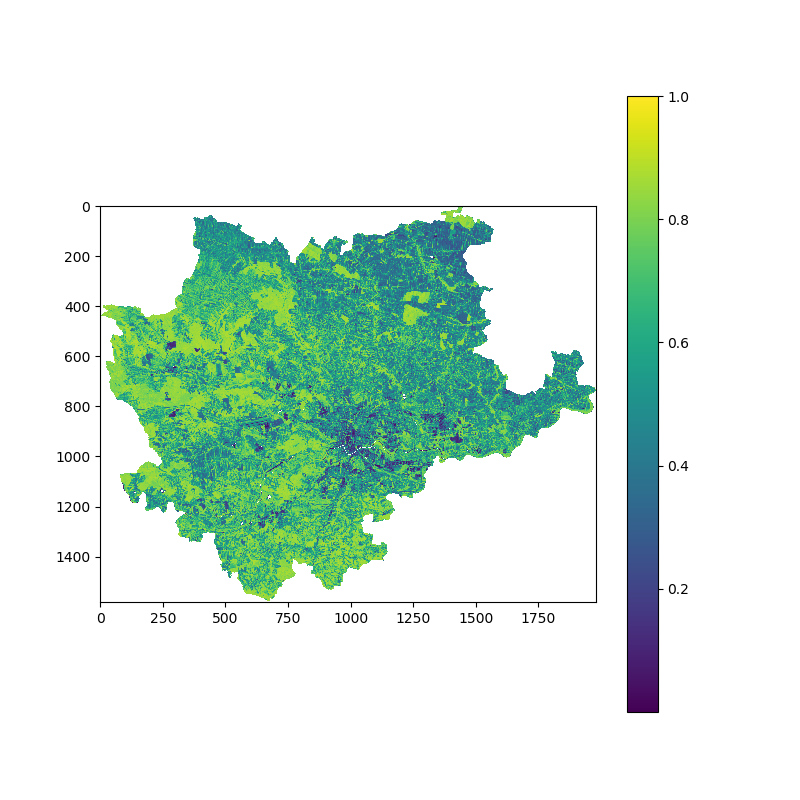

In [13]:
# 5. Oblicz NDVI

ndvi = oblicz_wskaznik('ndvi', lista_wycietych_obrazow)
ndvi[ndvi == 0] = -1
wyswietl_obraz(ndvi, mapa_kolorow='viridis', usun_ujemne=True)

<IPython.core.display.Javascript object>


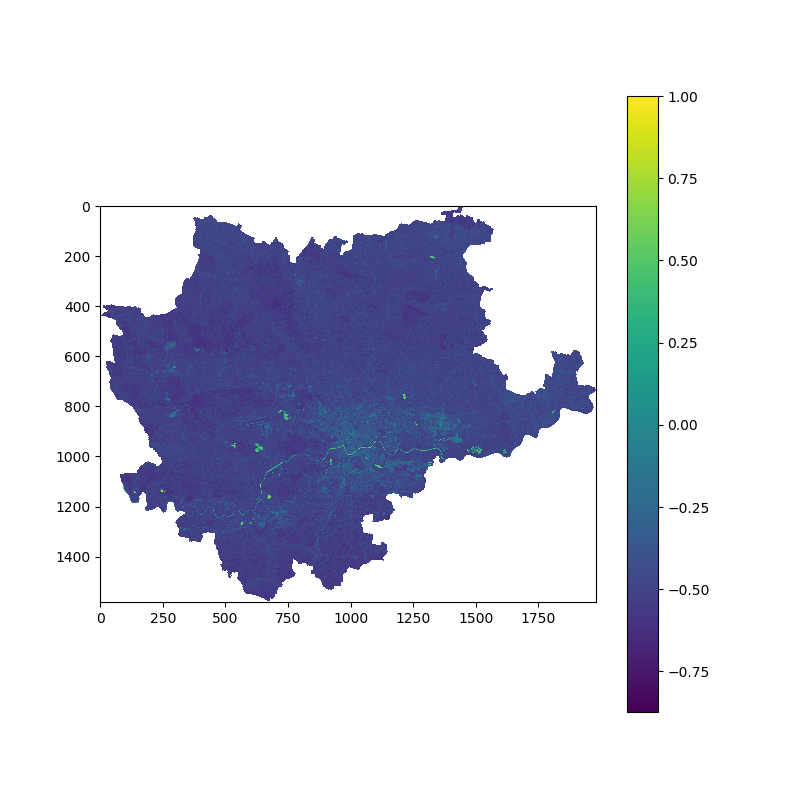

In [14]:
# 6. Oblicz NDWI

ndwi = oblicz_wskaznik('ndwi', lista_wycietych_obrazow)
ndwi[ndwi == 0] = np.nan
wyswietl_obraz(ndwi, mapa_kolorow='viridis', usun_ujemne=False)

<IPython.core.display.Javascript object>


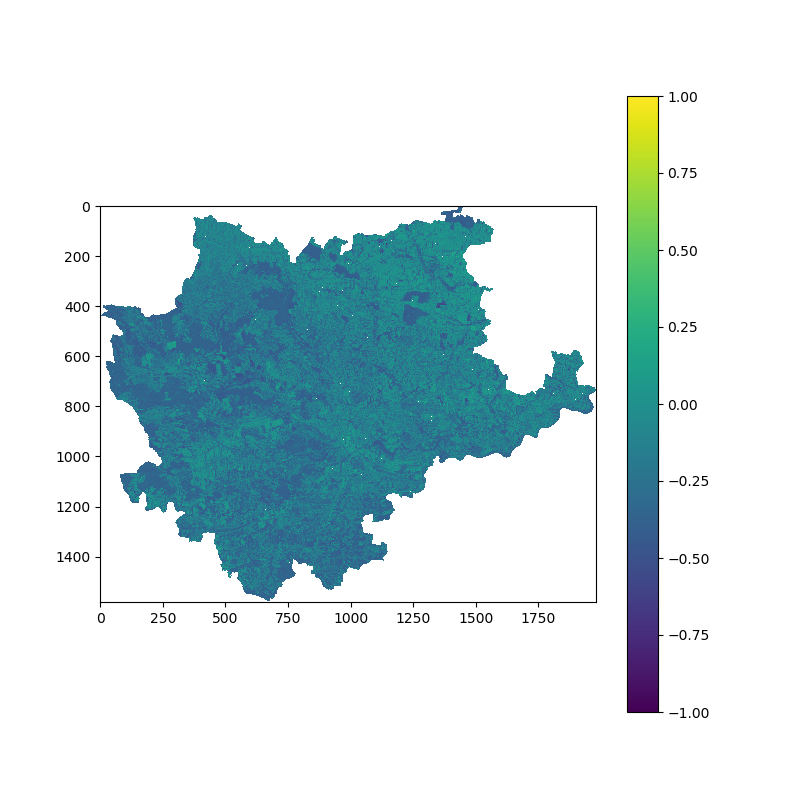

In [15]:
# 7. Oblicz NDBI

ndbi = oblicz_wskaznik('ndbi', lista_wycietych_obrazow)
ndbi[ndbi == 0] = np.nan
wyswietl_obraz(ndbi, mapa_kolorow='viridis', usun_ujemne=False)

<IPython.core.display.Javascript object>


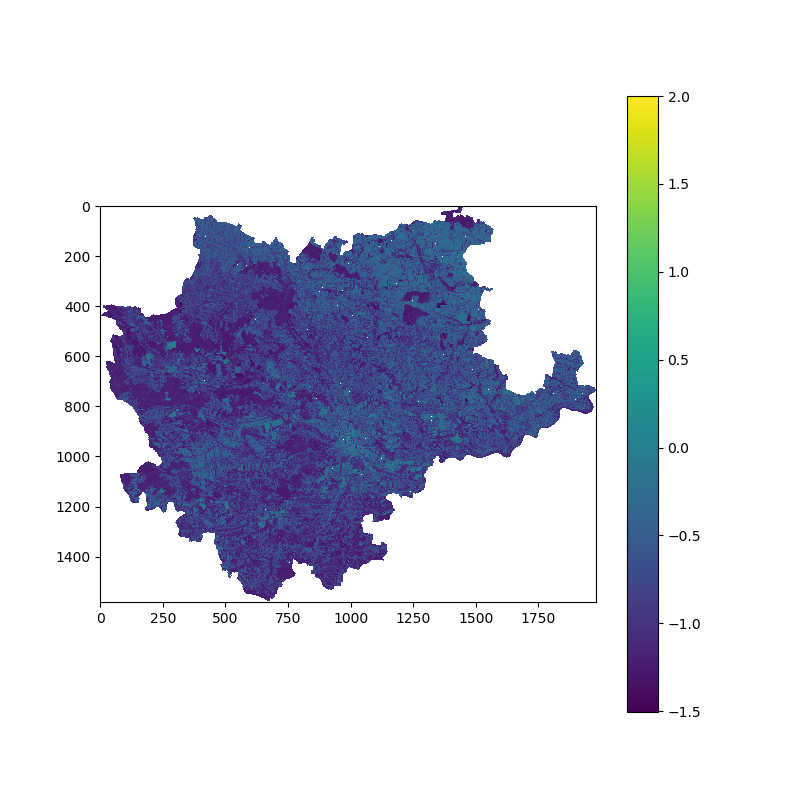

In [16]:
# 8. Różnica NDBI-NDVI

wyswietl_obraz(ndbi-ndvi, mapa_kolorow='viridis', usun_ujemne=False)